# Overview of this jupyter notebook

1. Loading the data
2. Optimize 1D-CNN Model for Multi-Label Classification with Kerastuner Bayesian
3. Evaluation of the optimized model and saving the results

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
import pickle
import json
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, clone_model, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
import keras_tuner as kt

In [3]:
import os
import importlib
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
print(importlib.reload(fapsc))
print(importlib.reload(ch))

<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>


In [4]:
# GPU check

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("TensorFlow version: ", tf.__version__)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Name: ", tf.test.gpu_device_name())
else:
    print("TensorFlow version: ", tf.__version__)
    print("GPU is not available")

TensorFlow version:  2.8.0
Num GPUs Available:  1
Name:  /device:GPU:0


# 1. Loading the data

In [5]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [6]:
feature_train = np.load("feature_label/feature_train_mlc_v2.4.npy")
feature_train.shape

(1550, 920)

In [7]:
feature_test = np.load("feature_label/feature_test_mlc_v2.4.npy")
feature_test.shape

(750, 920)

In [8]:
label_train = np.load("feature_label/label_train_mlc_v2.4.npy")
label_train.shape

(1550, 8)

In [9]:
label_test = np.load("feature_label/label_test_mlc_v2.4.npy")
label_test.shape

(750, 8)

In [10]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(feature_train, label_train, random_state=9)
x_test, y_test = shuffle(feature_test, label_test, random_state=9)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_test

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [11]:
len_curve = 920
x_train = x_train.reshape(-1, len_curve, 1)
x_test = x_test.reshape(-1, len_curve, 1)

x_train.shape, x_test.shape

((1550, 920, 1), (750, 920, 1))

# 2. Optimize 1D-CNN Model for Multi-Label Classification with Kerastuner Bayesian

In [12]:
x_train.shape

(1550, 920, 1)

In [13]:
class MyHyperModel(kt.HyperModel):
    
    def build(self, hp):
        try:
            conv_layer = hp.Int('conv_layer', min_value=4, max_value=4, step=1)
            filters = hp.Int('filter', min_value=16, max_value=64, step=16)
            kernel_size = hp.Int('kernel', min_value=16, max_value=16, step=4)
            maxpool = hp.Int('maxpool', min_value=2, max_value=3, step=1)
            bn_conv = hp.Choice('bn_conv', [True, False])
            bn_conv_position = hp.Int('bn_conv_position', min_value=1, max_value=conv_layer, step=1)
            dropout_conv = hp.Choice('dropout_conv', [True, False])
            dropout_rate = hp.Choice('dropout_rate', [0.1, 0.2, 0.3, 0.4])
            dense_layer = hp.Int('dense_layer', min_value=2, max_value=4, step=1)
            bn_dense = hp.Choice('bn_dense', [True, False])
            bn_dense_position = hp.Int('bn_dense_position', min_value=1, max_value=dense_layer, step=1)
            dropout_dense = hp.Choice('dropout_dense', [True, False])
        
        
            model = Sequential()

            for i in range(1, conv_layer+1):
                if i==1:
                    model.add(Conv1D(filters, kernel_size, activation="relu", input_shape=(len_curve, 1)))
                    model.add(MaxPooling1D(maxpool))
                    if (bn_conv==1) & (bn_conv_position==1):
                        model.add(BatchNormalization())
                        if dropout_conv:
                            model.add(Dropout(dropout_rate))
                else:
                    model.add(Conv1D(filters, kernel_size, activation="relu"))
                    model.add(MaxPooling1D(maxpool))
                    if (bn_conv==1) & (bn_conv_position==i):
                        model.add(BatchNormalization())
                        if dropout_conv:
                            model.add(Dropout(dropout_rate))

            model.add(Flatten())

            if dense_layer>=1:
                global unit1
                unit1 = hp.Int("unit1", min_value=200, max_value=400, step=40)
                model.add(Dense(unit1, activation='relu'))
                if (bn_dense==1) & (bn_dense_position==1):
                    model.add(BatchNormalization())
                    if dropout_dense:
                        model.add(Dropout(dropout_rate))

            if dense_layer>=2:
                global unit2
                unit2 = hp.Int("unit2", min_value=120, max_value=unit1, step=40)
                model.add(Dense(unit2, activation='relu'))
                if (bn_dense==1) & (bn_dense_position==2):
                    model.add(BatchNormalization())
                    if dropout_dense:
                        model.add(Dropout(dropout_rate))

            if dense_layer>=3:
                global unit3
                unit3 = hp.Int("unit3", min_value=80, max_value=unit2, step=40)
                model.add(Dense(unit3, activation='relu'))
                if (bn_dense==1) & (bn_dense_position==3):
                    model.add(BatchNormalization())
                    if dropout_dense:
                        model.add(Dropout(dropout_rate))

            if dense_layer>=4:
                global unit4
                unit4 = hp.Int("unit4", min_value=40, max_value=unit3, step=40)
                model.add(Dense(unit4, activation='relu'))
                if (bn_dense==1) & (bn_dense_position==4):
                    model.add(BatchNormalization())
                    if dropout_dense:
                        model.add(Dropout(dropout_rate))             

            model.add(Dense(8, activation='sigmoid'))

            lr = hp.Float("learning_rate", min_value=0.0001, max_value=0.01, sampling="log")
            model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=["accuracy"])

            print(model.summary())
            return model
        
        except:
            print(f"##### exception occured ###### \n")


    def fit(self, hp, model, *args, **kwargs):
        
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [4, 8, 16, 32, 64, 128]),
            **kwargs,
        )
        

In [14]:
tuner = kt.BayesianOptimization(MyHyperModel(),
                                objective="val_accuracy",
                                max_trials=400,          
                                seed=9,
                                overwrite=True,
                                directory='kerastuner', 
                                project_name="mlc_cnn_baysian_v2.4")

tuner.search(x_train, y_train, epochs=100, validation_split=0.25,
             callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

Trial 400 Complete [00h 01m 00s]
val_accuracy: 0.8969072103500366

Best val_accuracy So Far: 0.9278350472450256
Total elapsed time: 13h 15m 19s
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 905, 32)           544       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 301, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 286, 32)           16416     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 95, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 80, 32)            16416     
_________________________________________________________________
max_

In [15]:
best_hps.values

{'conv_layer': 4,
 'filter': 32,
 'kernel': 16,
 'maxpool': 3,
 'bn_conv': 1,
 'bn_conv_position': 4,
 'dropout_conv': 1,
 'dropout_rate': 0.1,
 'dense_layer': 2,
 'bn_dense': 1,
 'bn_dense_position': 2,
 'dropout_dense': 0,
 'unit1': 200,
 'unit2': 200,
 'learning_rate': 0.0001,
 'unit3': 80,
 'batch_size': 4,
 'unit4': 40}

In [16]:
#with open("results/mlc_cnn_kerastuner_bayesian_v2.4.json", "w") as f:
    json.dump(best_hps.values, f)
    f.close()

best_hps.values

{'conv_layer': 4,
 'filter': 32,
 'kernel': 16,
 'maxpool': 3,
 'bn_conv': 1,
 'bn_conv_position': 4,
 'dropout_conv': 1,
 'dropout_rate': 0.1,
 'dense_layer': 2,
 'bn_dense': 1,
 'bn_dense_position': 2,
 'dropout_dense': 0,
 'unit1': 200,
 'unit2': 200,
 'learning_rate': 0.0001,
 'unit3': 80,
 'batch_size': 4,
 'unit4': 40}

In [18]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 905, 32)           544       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 301, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 286, 32)           16416     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 95, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 80, 32)            16416     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 26, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 11, 32)           

In [19]:
def add_augmented_data(val_feat, val_label, augmentation_number, std=0.001):
    
    val_feat_aug = val_feat
    val_label_aug = val_label
    
    for i in range(augmentation_number):
        np.random.seed(i)
        noise = np.random.normal(0, std, val_feat.shape)
        augmented_data = val_feat + noise
        augmented_data[augmented_data<0] = 0
        val_feat_aug = np.concatenate((val_feat_aug, augmented_data), axis=0)
        val_label_aug = np.concatenate((val_label_aug, val_label), axis=0)

    print(val_feat_aug.shape, val_label_aug.shape)
    return val_feat_aug, val_label_aug

In [20]:
x_train_aug, y_train_aug = add_augmented_data(x_train, y_train, augmentation_number=3)
x_train_aug, y_train_aug = shuffle(x_train_aug, y_train_aug, random_state=9)
x_train_aug = x_train_aug.reshape(-1, len_curve, 1)

(6200, 920, 1) (6200, 8)


In [21]:
history = best_model.fit(x_train_aug, y_train_aug, epochs=100, batch_size=4, validation_split=0.2,
                         callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1)])

Epoch 1/100
1240/1240 [==============================] - 5s 4ms/step - loss: 0.4432 - accuracy: 0.6982 - val_loss: 0.2062 - val_accuracy: 0.8258
Epoch 2/100
1240/1240 [==============================] - 4s 4ms/step - loss: 0.2060 - accuracy: 0.8008 - val_loss: 0.0893 - val_accuracy: 0.8468
Epoch 3/100
1240/1240 [==============================] - 4s 3ms/step - loss: 0.1312 - accuracy: 0.8228 - val_loss: 0.0437 - val_accuracy: 0.8960
Epoch 4/100
1240/1240 [==============================] - 4s 3ms/step - loss: 0.1076 - accuracy: 0.8321 - val_loss: 0.0478 - val_accuracy: 0.8661
Epoch 5/100
1240/1240 [==============================] - 4s 3ms/step - loss: 0.0930 - accuracy: 0.8456 - val_loss: 0.0326 - val_accuracy: 0.8742
Epoch 6/100
1240/1240 [==============================] - 4s 3ms/step - loss: 0.0838 - accuracy: 0.8435 - val_loss: 0.0247 - val_accuracy: 0.8742
Epoch 7/100
1240/1240 [==============================] - 4s 4ms/step - loss: 0.0767 - accuracy: 0.8518 - val_loss: 0.0285 - val_ac

<module 'library.classification_helper' from 'D:\\MA_Songsik_Shin\\04_Code\\library\\classification_helper.py'>


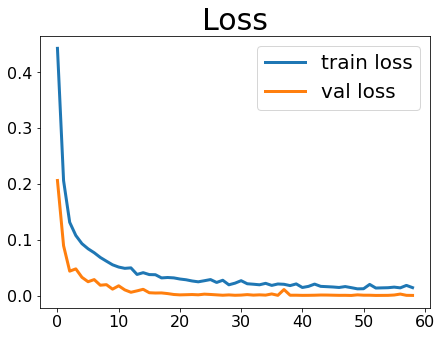

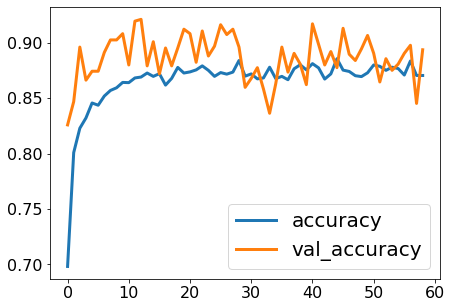

In [22]:
print(importlib.reload(ch))
ch.plot_history(history, figsize=(7,5))

In [25]:
#best_model.save('model/mlc_cnn_kersatuner_bayesian_v2.4.h5')

# 3. Evaluation of the optimized model and saving the results

In [12]:
best_model = load_model('model/mlc_cnn_kersatuner_bayesian_v2.4.h5')

In [13]:
prediction = best_model.predict(x_test)
y_pred = ch.make_pred_mlc(prediction, threshold=0.5)
acc, ham = ch.mlc_result(y_test, y_pred)



acc: 0.9213333333333333
hamming loss: 0.014166666666666666

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        50
           1      0.970     0.970     0.970       100
           2      0.989     0.935     0.961       200
           3      0.995     0.990     0.992       200
           4      0.858     0.910     0.883       100
           5      0.911     0.960     0.935       150
           6      0.986     0.967     0.976       150
           7      0.984     0.976     0.980       250

   micro avg      0.966     0.963     0.965      1200
   macro avg      0.962     0.963     0.962      1200
weighted avg      0.967     0.963     0.965      1200
 samples avg      0.969     0.969     0.964      1200



In [14]:
dfzip = ch.convert_and_zip_label(y_test, y_pred)
ch.cm_multi(dfzip)

Predicted,0,1,2,3,4,5,6,7,14,15,16,24,25,27,34,35,37,46,47,57,126,245,246,247,267,357,2467,Total
True,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
1,0,47,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
2,0,0,41,0,0,2,0,0,0,0,0,3,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,50
3,0,0,0,48,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,50
4,0,0,0,0,46,0,0,0,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,50
5,0,0,0,0,0,49,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,50
6,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
7,0,0,0,0,1,0,0,47,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,50
16,0,3,0,0,1,1,0,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50


In [16]:
res = ch.collect_results_mlc(y_test, y_pred, algorithm="cnn_kerastuner_bayesian", params="kerastuner_bayesian", 
                             best_param=best_param)
res

{'algorithm': 'cnn_kerastuner_bayesian',
 'params': 'kerastuner_bayesian',
 'best_param': {'conv_layer': 4,
  'filter': 32,
  'kernel': 16,
  'maxpool': 3,
  'bn_conv': 1,
  'bn_conv_position': 4,
  'dropout_conv': 1,
  'dropout_rate': 0.1,
  'dense_layer': 2,
  'bn_dense': 1,
  'bn_dense_position': 2,
  'dropout_dense': 0,
  'unit1': 200,
  'unit2': 200,
  'learning_rate': 0.0001,
  'unit3': 80,
  'batch_size': 4,
  'unit4': 40},
 'rec_0': 1.0,
 'pre_0': 1.0,
 'f1_0': 1.0,
 'rec_weighted': 0.9633333333333334,
 'pre_weighted': 0.966969513108492,
 'f1_weighted': 0.9648649827545845,
 'acc': 0.9213333333333333}

In [17]:
#ch.save_results_json(filename="mlc_algorithm_adaption_hyperopt_results_v2.4.json", 
                     key_algorithm = "cnn_kerastuner_bayesian", 
                     hyperopt_result = res)

existing file mlc_algorithm_adaption_hyperopt_results_v2.4.json opened and results of cnn_kerastuner_bayesian saved.
